In [1]:
from keras.applications.xception import Xception
import numpy as np

# x_test, y_test really means validation set in this notebook.
(x_train, y_train), (x_test, y_test) = np.load('data/room_dataset.npy')

base_model = Xception(include_top=False, weights='imagenet', pooling='avg')

# extract features by Xception
train_features = base_model.predict(x_train)
test_features = base_model.predict(x_test)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [31]:
import pandas as pd
from sklearn.decomposition import PCA

# try to visualize data along two principal components axes
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_features)

principalDf = pd.DataFrame(
    data = principalComponents, 
    columns = ['principal component 1', 'principal component 2']
)
principalDf['label'] = y_train

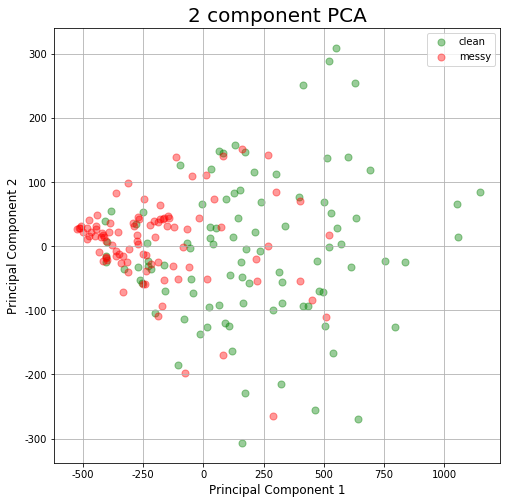

In [32]:
import matplotlib.pyplot as plt

# plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('2 component PCA', fontsize = 20)
labels = [0, 1]
colors = ['g', 'r']
classes = ['clean', 'messy']

for target, color in zip(labels, colors):
    indicesToKeep = principalDf['label'] == target
    ax.scatter(
        principalDf.loc[indicesToKeep, 'principal component 1'], 
        principalDf.loc[indicesToKeep, 'principal component 2'],
        c = color, s = 50, alpha=0.4
    )
ax.legend(classes)
ax.grid()
plt.show()


In [33]:
# The first two principal components retain ~80% of variance
pca.explained_variance_ratio_

array([0.752844  , 0.04933058], dtype=float32)

In [34]:
# To avoid overfitting, transform the data to fewer dimensions, retain 95% of variance
pca = PCA(0.95)
pca.fit(train_features) # fit on training set

train_transformed = pca.transform(train_features)
test_transformed = pca.transform(test_features)
pca.n_components_  # reduce to 18 dimensions

18

In [38]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_transformed, y_train)

# training and test accuracy
print('training acc: {:.2f}'.format(logisticRegr.score(train_transformed, y_train)))
print('test acc: {:.2f}'.format(logisticRegr.score(test_transformed, y_test)))

training acc: 0.86
test acc: 0.80


In [16]:
def plot_cm(cm, title, labels=('Positive', 'Negative')):
    """
    Plot a confusion matrix
    """

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    plt.xticks(np.arange(len(labels)), labels)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], fontsize=20, horizontalalignment='center')

In [24]:
from sklearn.metrics import confusion_matrix


train_predictions = logisticRegr.predict(train_transformed)
test_predictions = logisticRegr.predict(test_transformed)

# calculate confusion matrices
cm_train = confusion_matrix(y_train, train_predictions)
cm_test = confusion_matrix(y_test, test_predictions)
cm_train

array([[79, 17],
       [ 9, 87]])

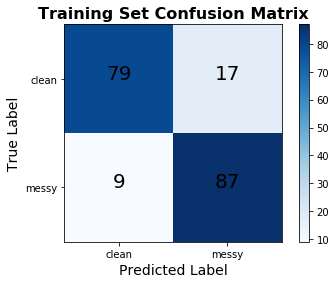

In [25]:
# training set confusion matrix
plot_cm(cm_train, 'Training Set Confusion Matrix', ['clean', 'messy'])

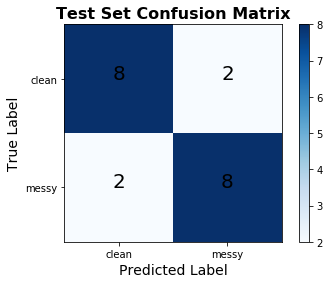

In [26]:
# test set confusion matrix
plot_cm(cm_test, 'Test Set Confusion Matrix', ['clean', 'messy'])

In [40]:
from sklearn import svm

# SVM with polynomial or gaussian kernel easily overfits
poly_svm = svm.SVC(kernel='poly')
poly_svm.fit(train_transformed, y_train)

print('training acc: {:.2f}'.format(poly_svm.score(train_transformed, y_train)))
print('test acc: {:.2f}'.format(poly_svm.score(test_transformed, y_test)))

training acc: 1.00
test acc: 0.55


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [41]:
# linear SVM result is comparable to logistic regression
lin_svm = svm.SVC(kernel='linear')
lin_svm.fit(train_transformed, y_train)

print('training acc: {:.2f}'.format(lin_svm.score(train_transformed, y_train)))
print('test acc: {:.2f}'.format(lin_svm.score(test_transformed, y_test)))

training acc: 0.86
test acc: 0.75
